# Image Classification

Part 0: Set Up Environment

Part 1: Load Data

Part 2: Explore Data

Part 3: Preprocess Data

Part 4: Build the Model

Part 5: Train the Neural Network

Part 6: Test the Model

## Part 0: Set Up Environment
[CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz): Labeled subsets of the 80 million tiny images dataset.

In [0]:
!ps -aux
# !kill -9 1356
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi

# OOM out of memory
# !top

USER         PID %CPU %MEM    VSZ   RSS TTY      STAT START   TIME COMMAND
root           1  0.0  0.0  39192  6460 ?        Ss   23:21   0:00 /bin/bash -e 
root           9  0.2  0.3 681660 46408 ?        Sl   23:21   0:00 /tools/node/b
root          19  0.8  0.7 402904 98068 ?        Sl   23:21   0:01 /usr/bin/pyth
root         119  0.0  0.0  35884  4744 ?        Ss   23:21   0:00 tail -n +0 -F
root         128  5.3  1.1 648572 152588 ?       Ssl  23:23   0:04 /usr/bin/pyth
root         178  0.0  0.0  59028  6464 ?        R    23:25   0:00 ps -aux
Sun Nov  3 23:25:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|============

In [0]:
!ls cifar-10-batches-py
!pwd

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch
/content


In [0]:
# urlretrieve lib: copy a network object denoted by a URL to a local file, if necessary
# tarfile lib: makes it possible to read and write tar archives, including those using gzip or bz2 compression.
# tqdm lib: Fast, Extensible Progress Meter

from urllib.request import urlretrieve
from os.path import isfile, isdir
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    print('downloading dataset...')
    urlretrieve(
        'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
        'cifar-10-python.tar.gz')

if not isdir(cifar10_dataset_folder_path):
    print('untar dataset...')
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


In [0]:
# python pickle: implements binary protocols for serializing and de-serializing a Python object structure.
import pickle
import numpy as np
import matplotlib.pyplot as plt

## Part 1: Load Data

The dataset is broken into batches to **prevent** machine from running **out of memory**. The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc..


Original data:


*   (10000 x 3072) dimensional tensor, numpy array
*   1000 sample data
*   3072 represents an color image of 32 x 32 pixels (= 32 x 32 x 3)
*   10 classes


In order to feed an image data into a CNN model, the dimension of the tensor representing an image data should be either (width x height x num_channel) or (num_channel x width x height). (The first one is the default one in TensorFlow)

In [0]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Reshape (3072):

Step 1. Reshape:

*   Divide the row vector (3072) into 3 pieces. Each piece corresponds to the each channels.
  - This results in (3 x 1024) dimension of tensor

*   Divide the resulting tensor from the previous step with 32. 32 here means width of an image.
  - This results in (3 x 32 x 32)

reshape(10000, 3, 32, 32): (num_channel, width, height)

Step 2. Transpose:

  transpose(1, 2, 0): (num_channel, width, height) --> (width, height, num_channel)

<img src="https://raw.githubusercontent.com/deep-diver/CIFAR10-img-classification-tensorflow/master/reshape-transpose.png" alt="Drawing" style="width: 800px;"/>

In [0]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        print(batch)
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

## Part 2: Explore Data


The display_stats defined below answers some of questions like in a given batch of data.
- "What are all possible labels?"
- "What is the range of values for the image data?"
- "Are the labels in order or random?"

In [0]:
# sample_id: the id for a image and label pair in the batch

def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 7001
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Part 3: Preprocess Data

### Part 3.1 Min-Max Normalization

**The images need to be normalized:**

- this simply makes all x values to range between 0 and 1.
- y = (x-min) / (max-min)

Reason:

1) Sigmoid activation function takes an input value and outputs a new value ranging from 0 to 1. When the input value is somewhat large, the output value easily reaches the max value 1. Similarily, when the input value is somewhat small, the output value easily reaches the max value 0. 

2) ReLU activation function takes an input value and outputs a new value ranging from 0 to infinity. When the input value is somewhat large, the output value increases linearly. However, when the input value is somewhat small, the output value easily reaches the max value 0. 


Now, when we think about the image data, all values originally ranges from 0 to 255. This sounds like when it is passed into sigmoid function, the output is almost always 1, and when it is passed into ReLu function, the output could be very huge. When backpropagation process is performed to optimize the networks, this could lead to an exploding gradient which leads to an aweful learning steps. In order to avoid this issue, ideally, it is better let all the values be around 0 and 1.

In [0]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

### Part 3.2: One-hot Encode

**The labels need to be one-hot encoded:**

Since the output of our model is going to show the probabilities of where an image should be categorized as a prediction. There should be a vector having the same number of elements as the number of image classes. For instance, CIFAR-10 provides 10 different classes of image, so we need a vector in size of 10 as well. Each element represents the predicting probability of each classes.

Also, our model should be able to compare the prediction with the ground truth label. It means the shape of the label data should also be transformed into a vector in size of 10 too. Instead, because label is the ground truth, we set the value 1 to the corresponding element.

**`one_hot_encode`** function takes the input, **`x`**, which is a list of labels(ground truth). The total number of element in the list is the total number of samples in a batch. **`one_hot_encode`** function returns a 2 dimensional tensor, where the number of row is the size of the batch, and the number of column is the number of image classes.

In [0]:
def one_hot_encode(x, num_classes=10):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), num_classes))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

### Part 3.3: Preprocess All the Data and Save it

Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation. 

<img src="https://raw.githubusercontent.com/deep-diver/CIFAR10-img-classification-tensorflow/master/train-valid-test%20split.png" alt="Drawing" style="width: 700px;"/>

In [0]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)
    print(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

In [0]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [0]:
# Checkpoint
import pickle

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))
#print(valid_features)
#print(valid_labels)

## Part 4: Build the Model

The image below depicts what the model would look like in this notebook.

<img src="https://raw.githubusercontent.com/deep-diver/CIFAR10-img-classification-tensorflow/master/conv_model.png" alt="Drawing" style="width: 1000px;"/>

### Part 4.1: Prepare Input for the Model

In [0]:
import tensorflow as tf

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
# A placeholder is simply a variable that we will assign data to at a later date.
# It allows us to create our operations and build our computation graph, without needing the data. 
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

### Part 4.2: Create Convolutional Model


The entire model consists of 14 layers in total. In addition to layers below lists what techniques are applied to build the model.

1. Convolution with 64 different filters in size of (3x3)
2. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
3. Convolution with 128 different filters in size of (3x3)
4. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
5. Convolution with 256 different filters in size of (3x3)
6. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
7. Convolution with 512 different filters in size of (3x3)
8. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
9. Flattening the 3-D output of the last convolutional operations.
10. Fully Connected Layer with 128 units
  - Dropout 
  - Batch Normalization
11. Fully Connected Layer with 256 units
  - Dropout 
  - Batch Normalization
12. Fully Connected Layer with 512 units
  - Dropout 
  - Batch Normalization
13. Fully Connected Layer with 1024 units
  - Dropout 
  - Batch Normalization
14. Fully Connected Layer with 10 units (number of image classes)

The image below decribes how the conceptual convolving operation differs from the tensorflow implementation when you use [Channel x Width x Height] tensor format. 

<img src="https://raw.githubusercontent.com/deep-diver/CIFAR10-img-classification-tensorflow/master/convolving.png" alt="Drawing" style="width: 1000px;"/>

Packages that contain APIs:

 tf.nn: lower level APIs for neural network
  - each APIs under this package has its sole purpose
  - you probably have to set lots of settings by yourself manually

tf.layers: higher level APIs for neural network
  - each APIs under this package probably has streamlined processes
  - each APIs under this package comes with lots of default setting in arguments
  
tf.contrib: contrib module containing volatile or experimental code
  - like the documents explain, this package provides experimental codes
  - you could probably find more handy APIs
  - you could look up this package when you don't find functionality under the main packages

Steps:
*   Define the dataflow graph
*   Create a TensorFlow session to run parts of the graph across a set of local and remote devices.

Here, we use APIs under each different packages.


In [0]:
def conv_net(x, keep_prob):
    # Create a variable.
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 256, 512], mean=0, stddev=0.08))

    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    # 9
    flat = tf.contrib.layers.flatten(conv4_bn)  

    # 10
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    # 12
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)    
    
    # 13
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)        
    
    # 14
    out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)
    return out

### Part 4.3: Hyperparameters

* `epochs`: number of iterations until the network stops learning or start overfitting
* `batch_size`: highest number that your machine has memory for.  Most people set them to common sizes of memory
* `keep_probability`: probability of keeping a node using dropout
* `learning_rate`: number how fast the model learns

In [0]:
epochs = 10
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

### Part 4.4: Cost Function & Optimizer

In [0]:
logits = conv_net(x, keep_prob)

model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


## Part 5: Train the Neural Network

### Part 5.1: Single Optimization

In [0]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, 
                feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: keep_probability
                })

In [0]:
# Show Stats
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

### Part 5.2: Helper Functions

In [0]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

### Part 5.3: Fully Train the Model

In [0]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                      
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2276 Validation Accuracy: 0.243000
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.8103 Validation Accuracy: 0.261800
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.4794 Validation Accuracy: 0.370800
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.6332 Validation Accuracy: 0.415200
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.5089 Validation Accuracy: 0.447600
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.3993 Validation Accuracy: 0.499800
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.1814 Validation Accuracy: 0.497400
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.2079 Validation Accuracy: 0.512600
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.2182 Validation Accuracy: 0.534200
Epoch  2, CIFAR-10 Batch 5:  Loss:     0.9704 Validation Accuracy: 0.588800
Epoch  3, CIFAR-10 Batch 1:  Loss:     0.9372 Validation Accuracy: 0.611200
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.8054 Validation Accuracy: 0.613400
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.7066 Validation Accuracy: 0.640800


## Part 6: Test Model

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random
from sklearn.preprocessing import LabelBinarizer

save_model_path = './image_classification'
batch_size = 64
n_samples = 5
top_n_predictions = 3


def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def display_image_predictions(features, labels, predictions, n_samples=10, n_predictions=3):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=n_samples, ncols=2, figsize=(10,10))
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    # n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]
        
        # print(image_i)
        # print(ind + margin)
        # print(pred_values[::-1])
        # print(width)
        
        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()
        
        
        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

        
def test_model(n_samples=10, top_n_predictions=3):
    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
         
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions, n_samples, top_n_predictions)




INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.7318869426751592



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


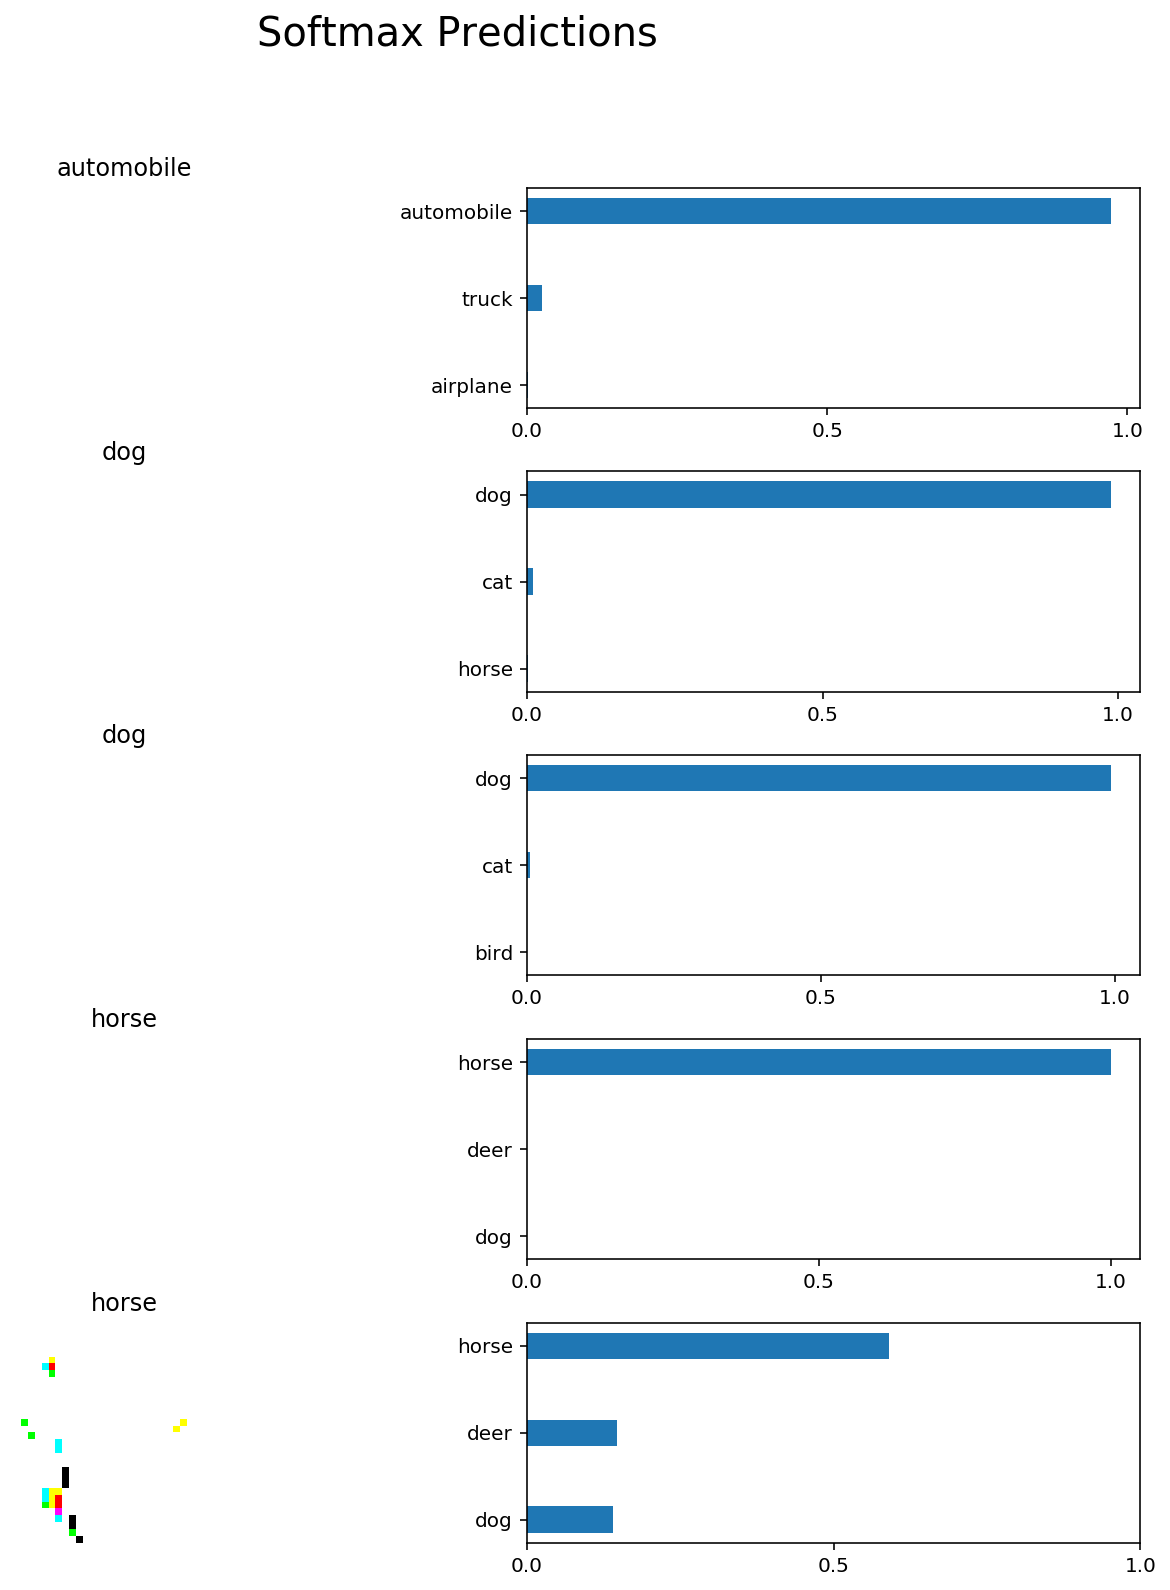

In [0]:
test_model(n_samples, top_n_predictions)